# Marginal Carbon Emissions

This notebook prototypes a method for calculating marginal carbon emissions for Great Britain. 

We will fit a function using a generalised additive model (GAM) to predict the grid carbon intensity as a function of net demand (demand minus uncontrollable renewables generaiton) and other power system variables; in this prototype we consider only wind and time of day, but this could easily be extended to more relevant variables. 

The model can then be used to estimate the carbon intensity under a hypothetical increase (or decrease) in net demand. The resulting CO2 emissions are then calculated from the change in load multiplied by the estimated carbon intensity.

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Data

This work will use data from Electric Insights (kindly pulled from their undercover API by Ayrton Bourn). The analysis will be based on 2019, the last year of complete data excluding 2020, which was unusual due to the pandemic. 

In [219]:
df = pd.read_csv('https://raw.githubusercontent.com/AyrtonB/Electric-Insights/master/data/electric_insights_2019.csv')

In [220]:
df['local_datetime'] = pd.to_datetime(df.local_datetime, utc=True)
df = df.set_index('local_datetime')
df = df.sort_index()

# Drop NAs for demand and carbon intensity
df = df.dropna(subset=['demand', 'gCO2_per_kWh'], axis=0)

# Add some datetime features
df['net_demand'] = df.demand - df.wind - df.solar
df['hour'] = df.index.hour
df['month'] = df.index.month - 1
df['dayofyear'] = df.index.dayofyear
df['sin_hour'] = np.sin(2*np.pi*df.hour / 24)
df['cos_hour'] = np.cos(2*np.pi*df.hour / 24)

### Checking for Outliers

Text(0, 0.5, 'gCO2 per kWh')

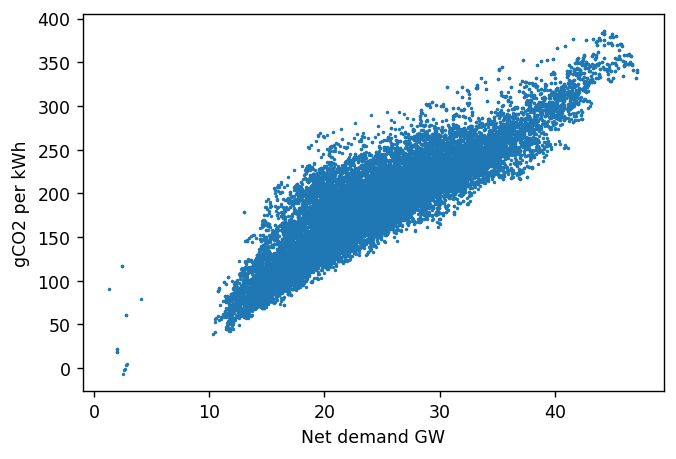

In [221]:
fig, ax = plt.subplots(dpi=125)
ax.scatter(df.net_demand, df.gCO2_per_kWh, s=1)
ax.set_xlabel('Net demand GW')
ax.set_ylabel('gCO2 per kWh')

Remove outyling points of low net demand: 

In [222]:
df = df[df.net_demand > 5]

There is a fairly clear relationship between net demand and gCO2 per kWh, but also a huge amount of noise: the carbon intensity for a net demand of 25 GW can be anywhere between ~130--300gCO2/kWh.

Panelling by hour gives a picture of the changing relationship between demand and CO2 intensity through the day:

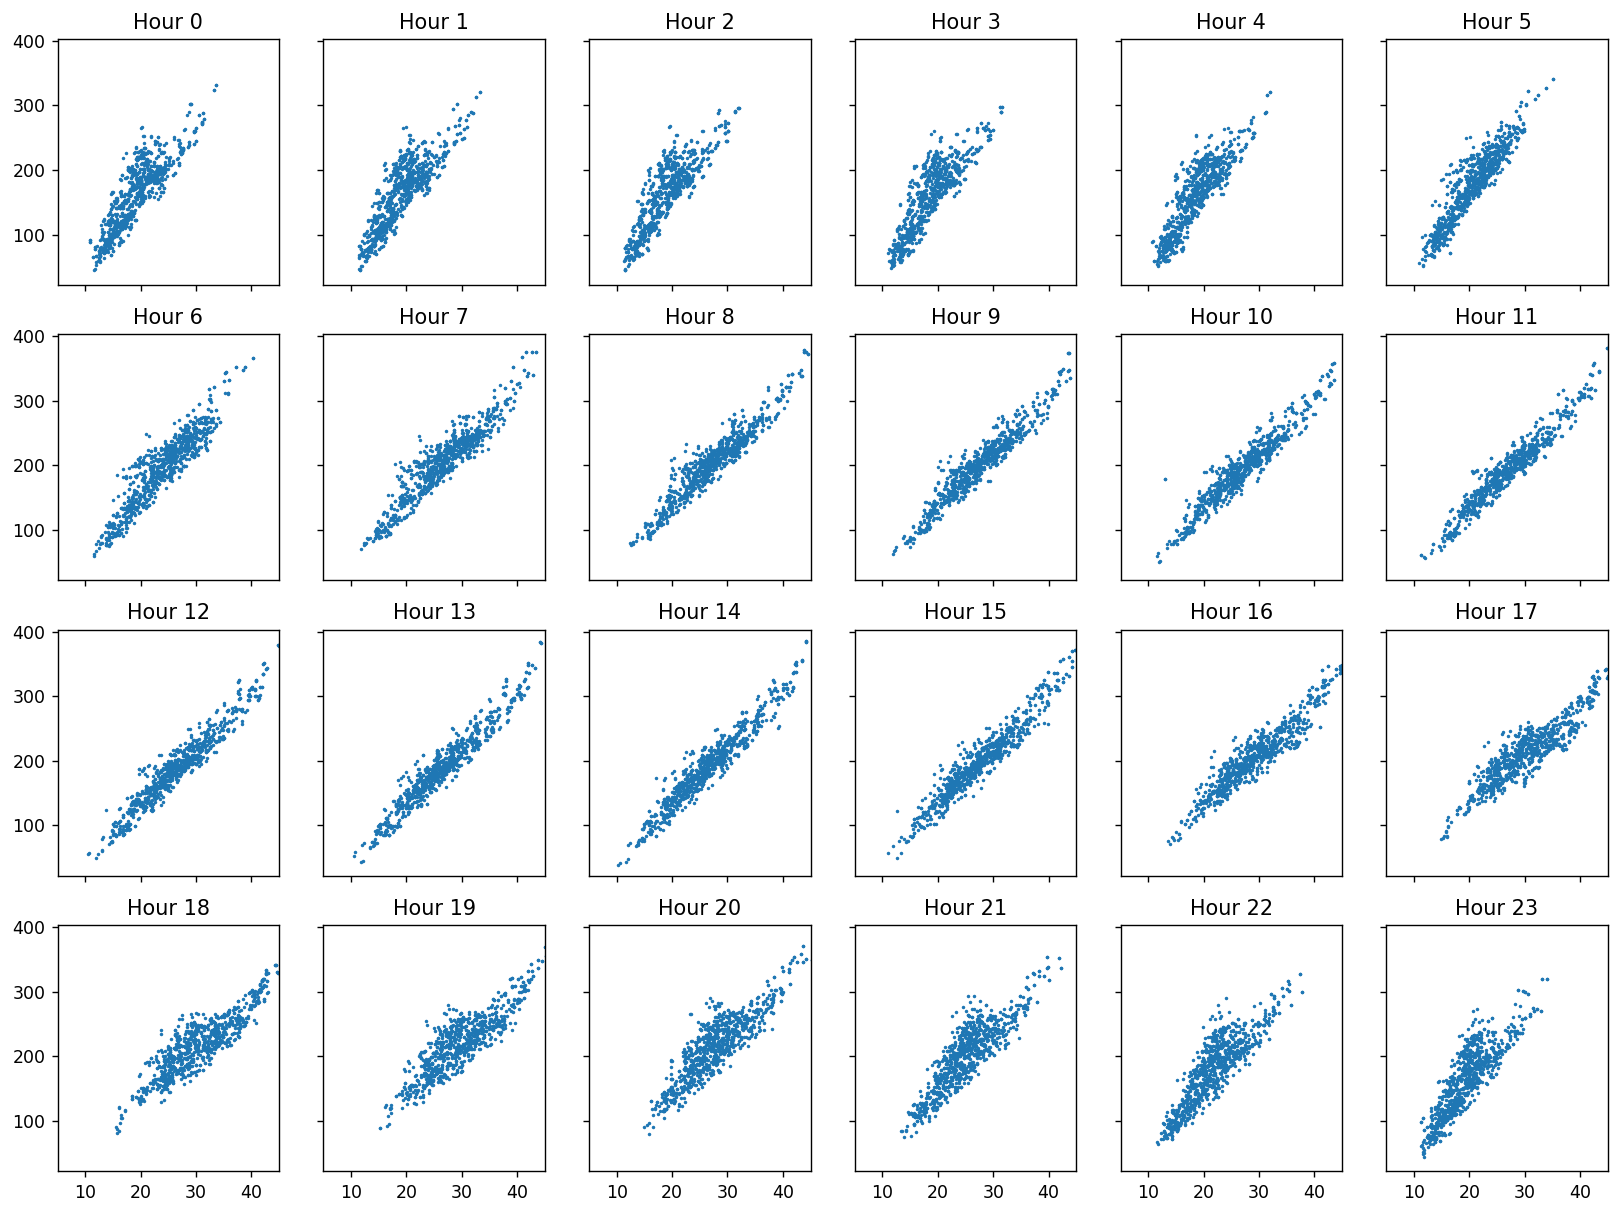

In [223]:
fig, axs = plt.subplots(4,6, dpi=125, figsize=(16,12), sharey=True, sharex=True)

rs = []
for i, ax in enumerate(axs.flatten()): 
    split = df.loc[df.index.hour == i].copy()
    
    ax.scatter(split.net_demand, split.gCO2_per_kWh, s=1)
    ax.set_title("Hour {}".format(i))
    ax.set_xlim(5, 45)
    
    r = stats.pearsonr(split.net_demand, split.gCO2_per_kWh)
    rs.append(r[0])
    
    

There is a much clearer relationship now if we control for hour (note binned approaches to CO2 intensity prediciton from the Wattime report). CO2 intensity is most strongly correlated with demand during daytime hours:

Text(0, 0.5, 'Pearson R')

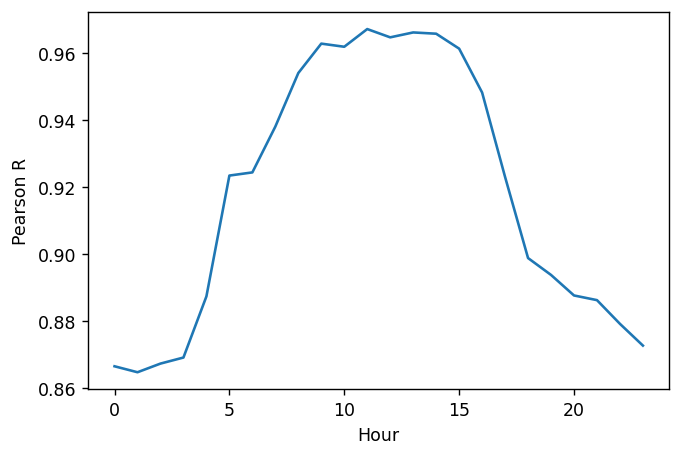

In [224]:
fig, ax = plt.subplots(dpi=125)

ax.plot(rs)
ax.set_xlabel('Hour')
ax.set_ylabel('Pearson R')

### GAMs

In this prototype we will apply generalised additive models (GAMs) to fit CO2 intensity against net demand and other power system variables.

In [225]:
from pygam import LinearGAM, s, f

Helper function to split the data into target (carbon intensity) and features:

In [226]:
def get_X_y(df, feature_cols):
    y = df['gCO2_per_kWh'].values.reshape(-1,)
    X = df.filter(feature_cols).values
    
    return X, y 

The following will use only a handful of features. One of the nice things about GAMs is their additive nature, which allows for the marginal impact of individual variables to be analysed. Keeping the number of features small adds to this interpretability, as well as reducing the risk of overfitting.

In [227]:
feature_cols = ['net_demand', 'sin_hour', 'cos_hour', 'wind']

### Data size vs. data relevance

Long-term changes in energy systems are likely to impact the relationship between demand and carbon intensity. Factors include fuel prices, introduction of new generation or interconnectors and changes to power market regulations which favour different generation technologies. 

Fitting models on windows of the data (e.g. single months, seasons etc.) may help to improve the intensity signal by controlling for long term changes which cannot easily be included in the model. However, this comes at the expense of less training data, and hence increased variance of the intensity signal. 

The code below investigates the effect of an increasing window size on model performance (MAE): 

In [230]:
np.random.seed(123)

window_size_days = [1, 2, 7, 30, 60, 180]
reps = 100
results = {size: [] for size in window_size_days}

for n_days in window_size_days:
    n_periods = n_days * 48 
    for i in range(reps):
        start_idx = np.random.randint(len(df - n_periods))
        end_idx = start_idx + n_periods
        split = df.iloc[start_idx:end_idx]
        
        # Train/test are sampled RANDOMLY: we are not interested in a forecast at this point
        test = split.sample(frac = 0.2)
        train = split.drop(test.index)
        
        X, y = get_X_y(train, feature_cols)
        
        # Fit GAM
        gam = LinearGAM(s(0, n_splines=15) + 
                        s(1, n_splines=15) +
                        s(2, n_splines=15) +
                        s(3, n_splines=15)).fit(X, y)

        # Make predictions
        X_test, y_test = get_X_y(test, feature_cols)
        y_pred = gam.predict(X_test)
        
        
        # Calculate MAE
        mae = mean_absolute_error(y_test, y_pred)
        results[n_days].append(mae)
        
results = pd.DataFrame.from_dict(results)
        

Plotting the results, we can see that MAE for very small window sizes (number of days) is large and highly variable. Variance in MAE decreases as the window size increases, but MAE also worsens. Fitting the carbon intensity model over a window of 2--7 days appears to be most appropriate (low error, small error bars). 

Text(0, 0.5, 'MAE')

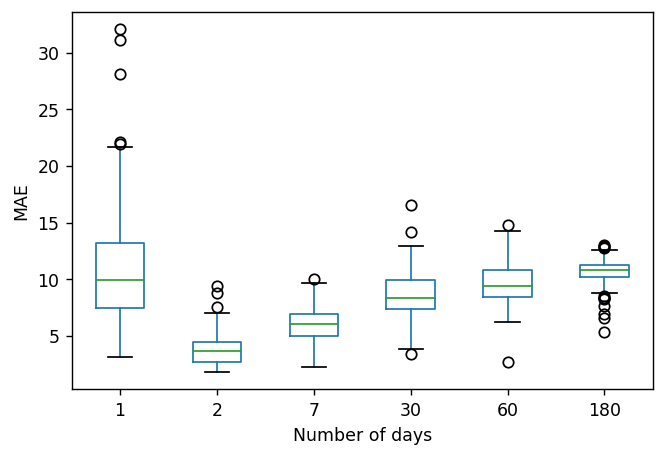

In [231]:
fig, ax = plt.subplots(dpi=125)

pd.DataFrame.from_dict(results).plot(kind='box', ax=ax)

ax.set_xlabel("Number of days")
ax.set_ylabel("MAE")

### Plotting the carbon intensity curve

Finally let's produce a carbon intensity curve for a given state, and determine the marginal carbon intensity signal.

While we have included that a weekly signal is most accurate, we will fit the model on the entire dataset for demonstrative purposes:

In [232]:
X, y = get_X_y(df, feature_cols)

gam = LinearGAM(s(0, n_splines=15) + 
                s(1, n_splines=15) +
                s(2, n_splines=15) +
                s(3, n_splines=15)).fit(X, y)

In [233]:
def hour_to_sin_cos(hour):
    """
    Convert hour (int) to sin and cos projection
    """
    sin_hour = np.sin(2*np.pi*hour / 24)
    cos_hour = np.cos(2*np.pi*hour / 24)
    
    return sin_hour, cos_hour

In [234]:
def predict_gCO2_per_kWh(gam, state, net_demands):
    """
    Predict carbon intensity given a fitted GAM, defined fixed state variables (dict)
    and net demands (array)
    """
    
    assert 'net_demand' in state.keys()
    
    state = pd.Series(state).astype(float)
    
    X = state.values
    X_rep = np.tile(X, (len(net_demands),1))
    X_rep[:, 0] = net_demands
    
    preds = gam.predict(X_rep)
    ints = gam.prediction_intervals(X_rep)
    
    return preds, ints
    

The state is defined below, requiring hour of day and wind (GW): 

In [235]:
hour = 10
wind = 5
N = 100
sin_hour, cos_hour = hour_to_sin_cos(hour)

state = {'net_demand': np.nan,
     'sin_hour': sin_hour,
     'cos_hour': cos_hour,
     'wind': wind}

net_demands = np.linspace(10, 40, N)

preds, ints = predict_gCO2_per_kWh(gam, state, net_demands)

The carbon intensity is plotted between 10--40 GW net demand, with wind and hour held steady: 

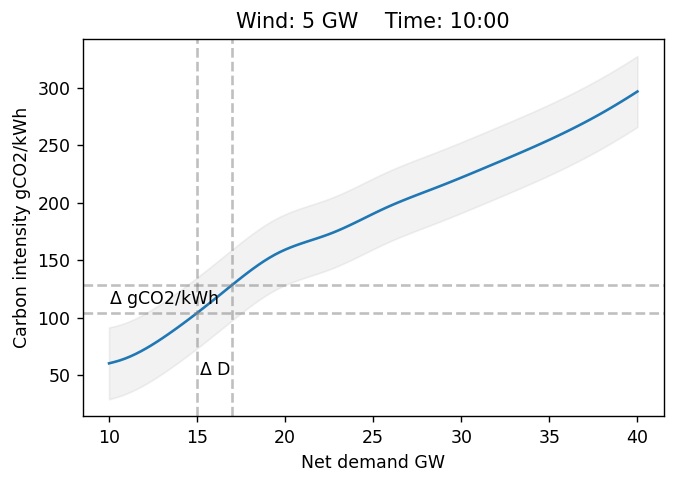

In [236]:
fig, ax = plt.subplots(dpi=125)

ax.plot(net_demands, preds)
ax.fill_between(net_demands, ints[:,0], ints[:,1], color='grey', alpha=0.1)

ax.set_xlabel("Net demand GW")
ax.set_ylabel("Carbon intensity gCO2/kWh")

ax.set_title("Wind: {} GW    Time: {}:00".format(wind, hour))

lwr = 15
upr = 17

y1 = predict_gCO2_per_kWh(gam, state, np.array([lwr]))[0]
y2 = predict_gCO2_per_kWh(gam, state, np.array([upr]))[0]

a = 0.5
c = 'gray'
ls = '--'
ax.axvline(lwr, color=c, alpha=a, linestyle=ls)
ax.axvline(upr, color=c, alpha=a, linestyle=ls)

ax.axhline(y1, color=c, alpha=a, linestyle=ls)
ax.axhline(y2, color=c, alpha=a, linestyle=ls)

ax.text((lwr + upr) / 2, 50, '$\Delta$ D', ha='center')
ax.text(10, (y1 + y2) / 2, '$\Delta$ gCO2/kWh', va='center')

plt.savefig('img/example_curve.png')

Using the graph, we can see what the change in carbon intensity would be if net demand increase by a given $\Delta D$. Using this, we can determine a marginal carbon emissions signal for a given $\Delta D$. The code below calculates this signal based a $d$ MWh load (equivalent to a $2d$ MW increase in net demand over 30 mins).  

In [237]:
def marginal_carbon_emissions_kgCO2(gam, state, net_demand, MWh = 1): 
    """
    Calculate the carbon emissions change (kgCO2) for a MWh increase in 
    net demand (equates to a (2 * MWh) MW average power over 30 mins)
    """
    # Calculate 
    pred = predict_gCO2_per_kWh(gam, state, np.array([net_demand + MWh * 2 * 1e-3]))[0]
    
    # Just being really explicit here about kgCO2! 
    gCO2 = pred * 1e3 # carbon emissions (gCO2) for 1MWh demand
    kgCO2 = gCO2 / 1e3 # convert gCO2 to kgCO2
    return kgCO2
    
float(marginal_carbon_emissions_kgCO2(gam, state, 25, 100))

191.8266116710167

Now for each period in the original data for January, we will calculate the marginal CO2 emissions for a 1 MWh increase in demand: 

In [241]:
all_marginals = []
df_jan = df.loc[df.index < '2019-02-01'].copy()

for i, row in df_jan.iterrows():
    row = row.filter(feature_cols)
    all_marginals.append(float(marginal_carbon_emissions_kgCO2(gam, row, row['net_demand'])))
            
df_jan['marginal_carbon_emissions_kgCO2_per_MWh'] = all_marginals

Text(0.5, 1.0, '1 MWh increase')

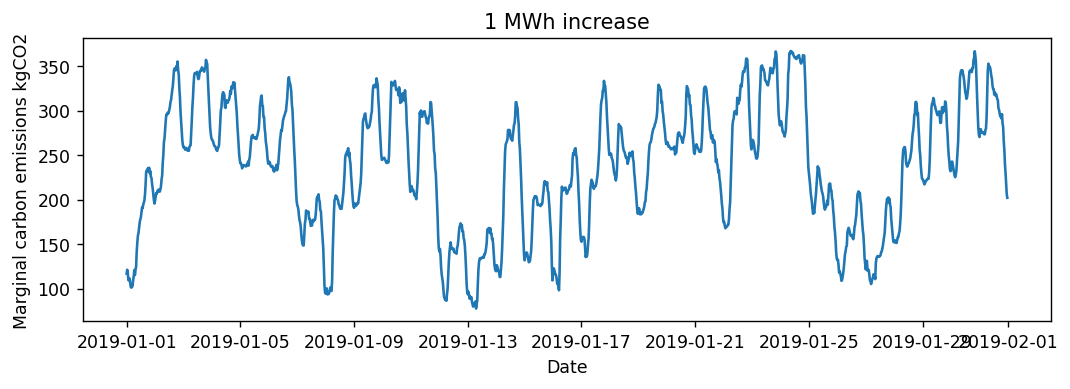

In [242]:
fig, ax = plt.subplots(dpi=125, figsize=(10,3))

ax.plot(df_jan.marginal_carbon_emissions_kgCO2_per_MWh)
ax.set_xlabel("Date")
ax.set_ylabel("Marginal carbon emissions kgCO2")
ax.set_title("1 MWh increase")


Text(0.5, 1.0, '1 MWh increase')

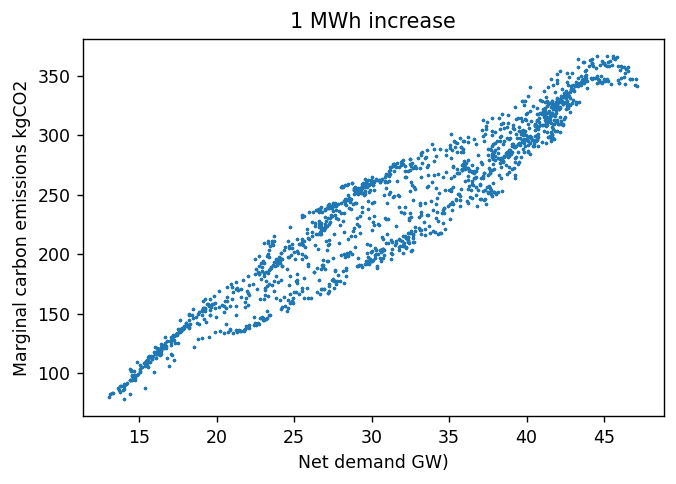

In [243]:
fig, ax = plt.subplots(dpi=125)

ax.scatter(df_jan.net_demand, df_jan.marginal_carbon_emissions_kgCO2_per_MWh, s=1)
ax.set_xlabel("Net demand GW)")
ax.set_ylabel("Marginal carbon emissions kgCO2")
ax.set_title("1 MWh increase")